In [6]:
# assert all train q-a pairs has 1 explanation

notthree = sum([1 for k, v in test_data.items() if len(v['explanation']) != 3])
print(f"Test data with not 3 explanations: {notthree}/{len(test_data)}")

notthree = sum([1 for k, v in val_data.items() if len(v['explanation']) != 3])
print(f"Val data with not 3 explanations: {notthree}/{len(val_data)}")

number_of_explanations_train = [len(v['explanation']) for k, v in train_data.items()]
for i in list(set(number_of_explanations_train)):
    print(f"Number of explanations in train data: {i}: {number_of_explanations_train.count(i)}")

Test data with not 3 explanations: 0/1968
Val data with not 3 explanations: 0/1459
Number of explanations in train data: 1: 27383
Number of explanations in train data: 2: 2075
Number of explanations in train data: 3: 1


## Verify Dataset's Statistics

In [2]:
import json
import pandas as pd
from collections import Counter
import re

# Load datasets
def load_datasets():
    with open('../../../datasets/VQA-X/vqaX_train.json', 'r') as f:
        original_train_data = json.load(f)
    with open('../../../datasets/VQA-X/vqaX_val.json', 'r') as f:
        original_val_data = json.load(f)
    with open('../../../datasets/VQA-X/vqaX_test.json', 'r') as f:
        original_test_data = json.load(f)
    
    translated_train_data = pd.read_csv('../../../datasets/VQA-X/final_data/post_processing/vqaX_train_translated.csv')
    translated_val_data = pd.read_csv('../../../datasets/VQA-X/final_data/post_processing/vqaX_val_translated.csv')
    translated_test_data = pd.read_csv('../../../datasets/VQA-X/final_data/post_processing/vqaX_test_translated.csv')
    
    return (original_train_data, original_val_data, original_test_data,
            translated_train_data, translated_val_data, translated_test_data)

# Clean text using regex
def clean_text(text):
    return re.sub(r'[^A-Za-z0-9À-ỹ\s]', '', text.strip())

# Get the most common answer
def get_most_common_answer(answers):
    cleaned_answers = [clean_text(answer['answer']) for answer in answers]
    return Counter(cleaned_answers).most_common(1)[0][0]

# Calculate statistics
def calculate_stats(data, dataset_name, is_translated=False):
    image_ids = set()
    unique_questions = set()
    unique_answers = set()
    explanations = []
    vocab = set()

    if is_translated:
        for _, row in data.iterrows():
            unique_questions.add(clean_text(row['question']))
            unique_answers.add(clean_text(row['answer']))
            explanation_list = row['explanation'].split('###')
            explanations.extend(explanation_list)
            for exp in explanation_list:
                vocab.update([clean_text(exp) for exp in exp.split()])
            image_ids.add(row['img_id'])
    else:
        for item in data.values():
            image_ids.add(item['image_id'])
            unique_questions.add(clean_text(item['question']))
            most_common_answer = get_most_common_answer(item['answers'])
            unique_answers.add(most_common_answer)
            explanations.extend(item['explanation'])
            for exp in item['explanation']:
                vocab.update([clean_text(exp) for exp in exp.split()])

    avg_words_per_expl = sum(len(expl.split()) for expl in explanations) / len(explanations)
    vocab_df = pd.DataFrame(list(vocab), columns=['Vocabulary'])
    vocab_df.sort_values(by='Vocabulary', inplace=True)
    vocab_df.to_csv(f'../../../datasets/VQA-X/stats/vocab_{dataset_name}.csv', index=False)
    
    return {
        "#Imgs": image_ids,
        "#Q/A Pairs": len(data),
        "#Unique Q.": unique_questions,
        "#Unique A.": unique_answers,
        "#Expl.": len(explanations),
        "Avg. #w": round(avg_words_per_expl, 2),
        "Vocab Size": vocab
    }

# Calculate total statistics
def calculate_total_stats(train_stats, val_stats, test_stats):
    total_image_ids = train_stats["#Imgs"] | val_stats["#Imgs"] | test_stats["#Imgs"]
    total_questions = train_stats["#Unique Q."] | val_stats["#Unique Q."] | test_stats["#Unique Q."]
    total_answers = train_stats["#Unique A."] | val_stats["#Unique A."] | test_stats["#Unique A."]
    total_vocab = train_stats["Vocab Size"] | val_stats["Vocab Size"] | test_stats["Vocab Size"]
    
    return {
        "#Imgs": len(total_image_ids),
        "#Q/A Pairs": train_stats["#Q/A Pairs"] + val_stats["#Q/A Pairs"] + test_stats["#Q/A Pairs"],
        "#Unique Q.": len(total_questions),
        "#Unique A.": len(total_answers),
        "#Expl.": train_stats["#Expl."] + val_stats["#Expl."] + test_stats["#Expl."],
        "Avg. #w": round((
            (train_stats["Avg. #w"] * train_stats["#Expl."]) +
            (val_stats["Avg. #w"] * val_stats["#Expl."]) +
            (test_stats["Avg. #w"] * test_stats["#Expl."])
        ) / (train_stats["#Expl."] + val_stats["#Expl."] + test_stats["#Expl."]), 2),
        "Vocab Size": len(total_vocab)
    }

# Main function to calculate and aggregate statistics
def main():
    (original_train_data, original_val_data, original_test_data,
     translated_train_data, translated_val_data, translated_test_data) = load_datasets()
    
    splits = ['train', 'val', 'test']
    original_stats = [calculate_stats(data, split) for data, split in zip(
        [original_train_data, original_val_data, original_test_data], splits)]
    translated_stats = [calculate_stats(data, split, is_translated=True) for data, split in zip(
        [translated_train_data, translated_val_data, translated_test_data], splits)]
    
    original_stats_df = pd.DataFrame([{
        "#Imgs": len(stats["#Imgs"]),
        "#Q/A Pairs": stats["#Q/A Pairs"],
        "#Unique Q.": len(stats["#Unique Q."]),
        "#Unique A.": len(stats["#Unique A."]),
        "#Expl.": stats["#Expl."],
        "Avg. #w": stats["Avg. #w"],
        "Vocab Size": len(stats["Vocab Size"])
    } for stats in original_stats], index=splits)
    
    translated_stats_df = pd.DataFrame([{
        "#Imgs": len(stats["#Imgs"]),
        "#Q/A Pairs": stats["#Q/A Pairs"],
        "#Unique Q.": len(stats["#Unique Q."]),
        "#Unique A.": len(stats["#Unique A."]),
        "#Expl.": stats["#Expl."],
        "Avg. #w": stats["Avg. #w"],
        "Vocab Size": len(stats["Vocab Size"])
    } for stats in translated_stats], index=splits)
    
    total_original_stats = calculate_total_stats(*original_stats)
    total_translated_stats = calculate_total_stats(*translated_stats)
    original_stats_df.loc['total'] = total_original_stats
    translated_stats_df.loc['total'] = total_translated_stats
    
    return original_stats_df, translated_stats_df

# Output the final DataFrame
original_stats_df, translated_stats_df = main()
original_stats_df

#Imgs  #Q/A Pairs  #Unique Q.  #Unique A.  #Expl.  Avg. #w  Vocab Size
train  24876       29459       12985        1147   31536     8.55        8394
val     1431        1459         814         246    4377     8.89        3220
test    1921        1968         902         272    5904     8.94        3566
total  28180       32886       13972        1236   41817     8.64        9379

In [28]:
translated_stats_df

#Imgs  #Q/A Pairs  #Unique Q.  #Unique A.  #Expl.  Avg. #w  Vocab Size
train  24876       29459       14544        1460   31536     9.93        3909
val     1431        1459         937         300    4377    10.23        2052
test    1921        1968        1101         341    5904    10.32        2095
total  28180       32886       15701        1634   41817    10.02        4232

## Verify Complementary Pairs

In [21]:
import json
import pandas as pd

stats_folder = '../../../datasets/VQA-X/stats'
import os
os.makedirs(stats_folder, exist_ok=True)
# Đọc file json của bộ VQAv2
def load_complementary_pairs(file_path):
    with open(file_path, 'r') as f:
        complementary_pairs = json.load(f)
    return complementary_pairs

# Đường dẫn đến các file complementary pairs của VQAv2
vqa_train_complementary_file = '/home/VLAI/datasets/VQAv2/v2_mscoco_train2014_complementary_pairs.json'
vqa_val_complementary_file = '/home/VLAI/datasets/VQAv2/v2_mscoco_val2014_complementary_pairs.json'

# Load complementary pairs của VQAv2
vqa_train_complementary_pairs = load_complementary_pairs(vqa_train_complementary_file)
vqa_val_complementary_pairs = load_complementary_pairs(vqa_val_complementary_file)

# Tổng hợp lại tất cả complementary pairs của VQAv2 (train + val)
vqa_complementary_pairs = set(map(tuple, vqa_train_complementary_pairs + vqa_val_complementary_pairs))

# Hàm để tạo danh sách các cặp complementary từ dataset gốc (sử dụng question_id)
def get_complementary_pairs_from_vqax(df, vqa_complementary_pairs):
    question_ids = set(df['question_id'])
    complementary_pairs = set()
    
    # Kiểm tra từng cặp trong complementary_pairs của VQAv2 xem có tồn tại trong dataset gốc không
    for pair in vqa_complementary_pairs:
        if pair[0] in question_ids and pair[1] in question_ids:
            complementary_pairs.add(pair)
    
    return complementary_pairs

# Đọc dataset của VQAX
vqax_train = pd.read_csv('/home/VLAI/datasets/VQA-X/final_data/post_processing/vqaX_train_translated.csv')
vqax_val = pd.read_csv('/home/VLAI/datasets/VQA-X/final_data/post_processing/vqaX_val_translated.csv')
vqax_test = pd.read_csv('/home/VLAI/datasets/VQA-X/final_data/post_processing/vqaX_test_translated.csv')

# Tạo cặp complementary từ dataset gốc (train, val, test)
complementary_pairs_train = get_complementary_pairs_from_vqax(vqax_train, vqa_complementary_pairs)
complementary_pairs_val = get_complementary_pairs_from_vqax(vqax_val, vqa_complementary_pairs)
complementary_pairs_test = get_complementary_pairs_from_vqax(vqax_test, vqa_complementary_pairs)

# So sánh số lượng cặp complementary trùng khớp giữa dataset gốc và VQAv2 cho từng tập
matching_complementary_pairs_train = complementary_pairs_train & vqa_complementary_pairs
matching_complementary_pairs_val = complementary_pairs_val & vqa_complementary_pairs
matching_complementary_pairs_test = complementary_pairs_test & vqa_complementary_pairs

# In ra kết quả cho từng tập
print(f"Số lượng cặp complementary trùng khớp trong tập train: {len(matching_complementary_pairs_train)}")
print(f"Số lượng cặp complementary trùng khớp trong tập val: {len(matching_complementary_pairs_val)}")
print(f"Số lượng cặp complementary trùng khớp trong tập test: {len(matching_complementary_pairs_test)}")

# Tổng hợp số lượng cặp complementary trùng khớp giữa train, val, test
total_matching_complementary_pairs = matching_complementary_pairs_train | matching_complementary_pairs_val | matching_complementary_pairs_test

# In ra tổng số lượng cặp complementary trùng khớp
print(f"Tổng số lượng cặp complementary trùng khớp trong dataset gốc: {len(total_matching_complementary_pairs)}")
# Lưu kết quả ra file CSV
pair_train_df = pd.DataFrame(list(complementary_pairs_train), columns=['question_id_1', 'question_id_2'])
pair_val_df = pd.DataFrame(list(complementary_pairs_val), columns=['question_id_1', 'question_id_2'])
pair_test_df = pd.DataFrame(list(complementary_pairs_test), columns=['question_id_1', 'question_id_2'])

pair_train_df.to_csv('/home/VLAI/datasets/VQA-X/stats/complementary_pairs_train.csv', index=False)
pair_val_df.to_csv('/home/VLAI/datasets/VQA-X/stats/complementary_pairs_val.csv', index=False)
pair_test_df.to_csv('/home/VLAI/datasets/VQA-X/stats/complementary_pairs_test.csv', index=False)

Số lượng cặp complementary trùng khớp trong tập train: 6050
Số lượng cặp complementary trùng khớp trong tập val: 240
Số lượng cặp complementary trùng khớp trong tập test: 510
Tổng số lượng cặp complementary trùng khớp trong dataset gốc: 6800


## Visualize dataset statistic

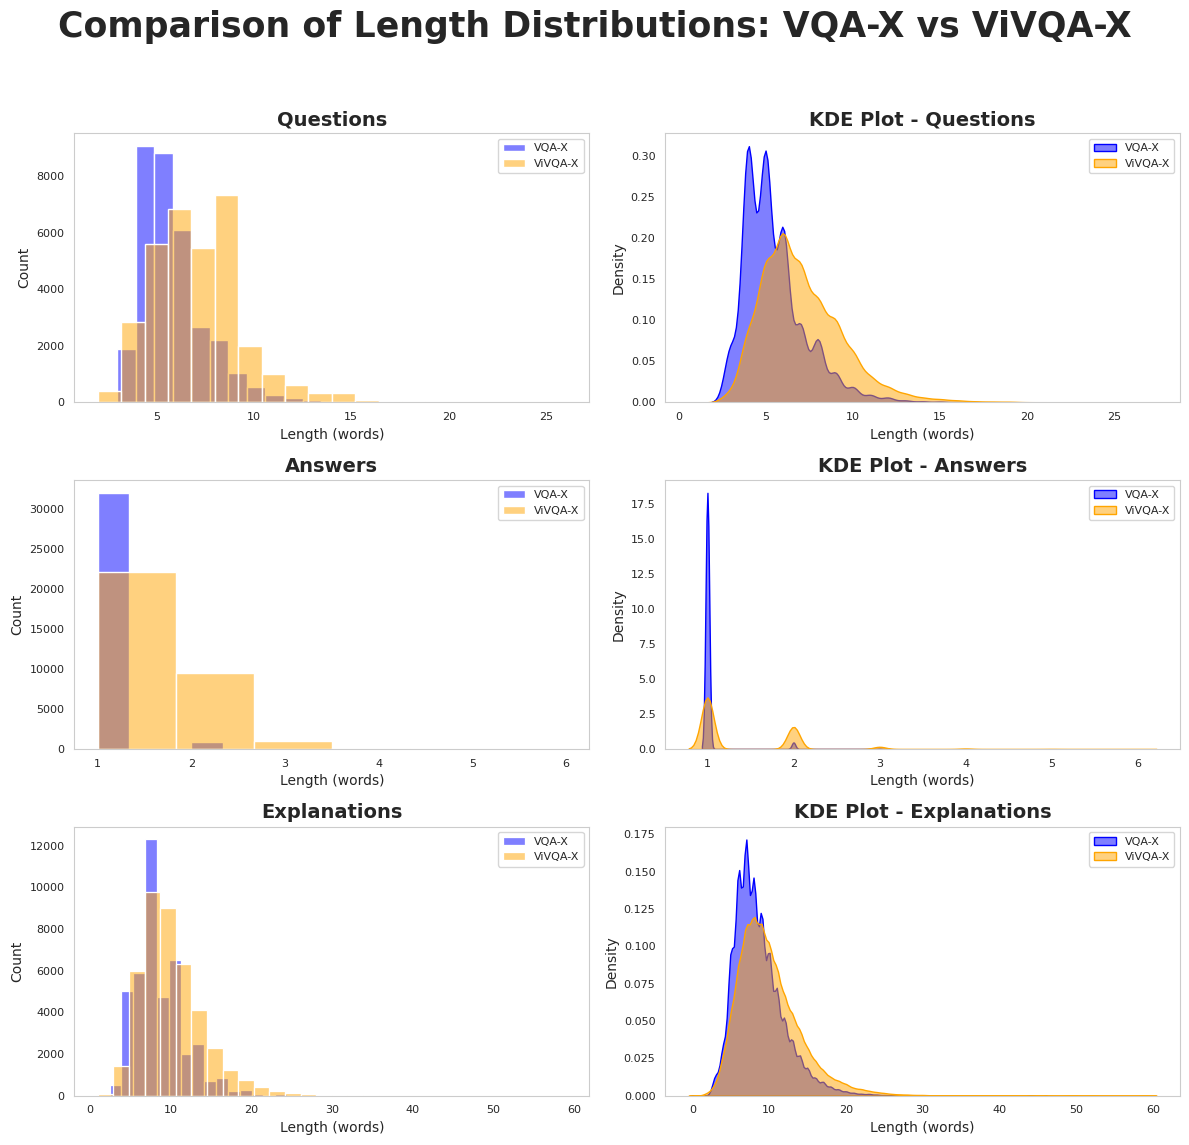

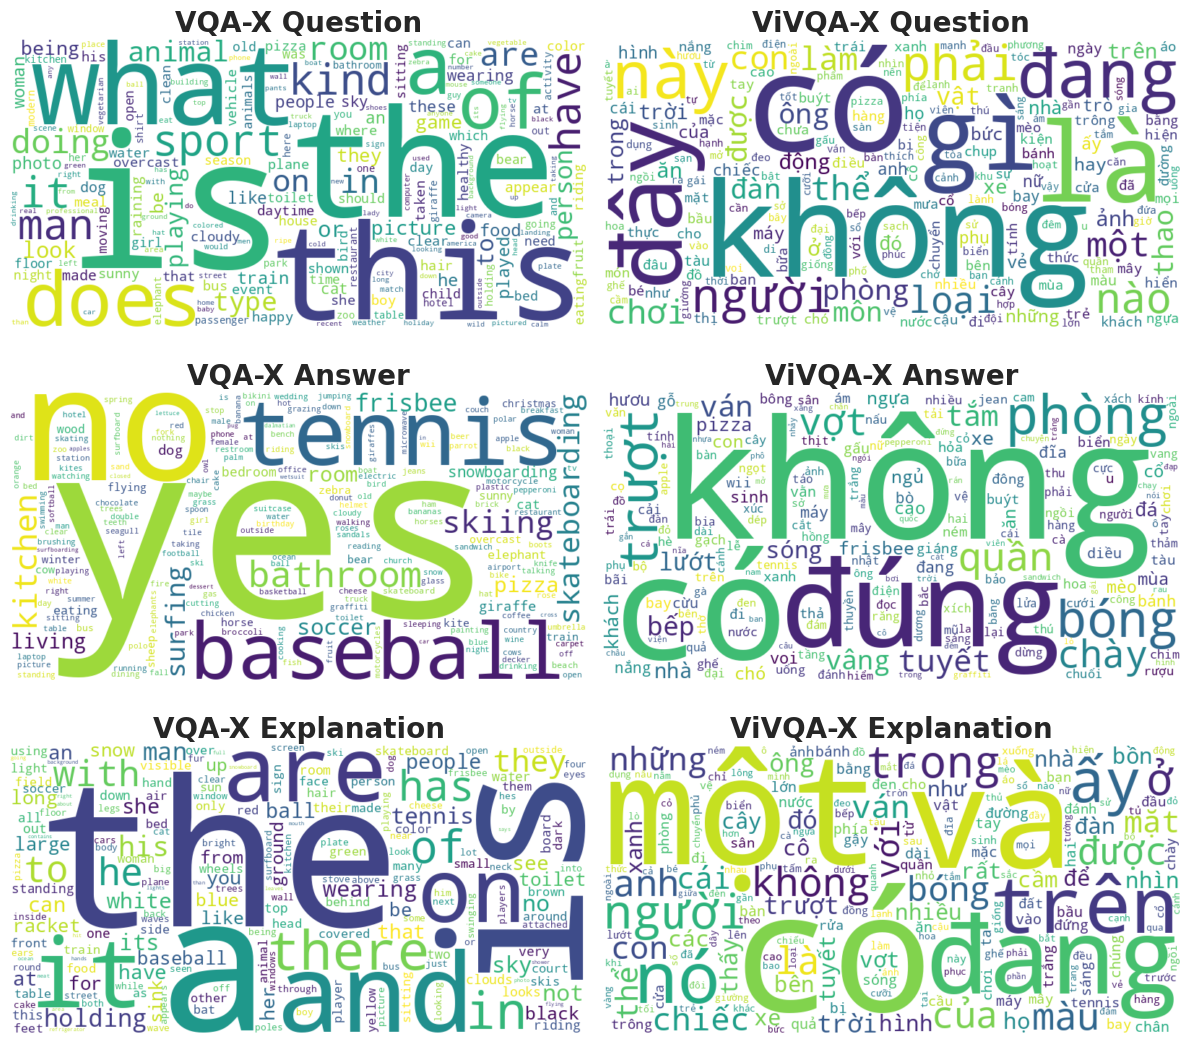

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import json
import pandas as pd

sns.set_style("whitegrid")

def clean_text(text):
    return re.sub(r'[^A-Za-z0-9À-ỹ\s]', '', text.strip())

def get_most_common_answer(answers):
    cleaned_answers = [clean_text(answer['answer']) for answer in answers]
    return Counter(cleaned_answers).most_common(1)[0][0]

def load_datasets():
    with open('../../../datasets/VQA-X/vqaX_train.json', 'r') as f:
        original_train_data = json.load(f)
    with open('../../../datasets/VQA-X/vqaX_val.json', 'r') as f:
        original_val_data = json.load(f)
    with open('../../../datasets/VQA-X/vqaX_test.json', 'r') as f:
        original_test_data = json.load(f)
    
    translated_train_data = pd.read_csv('../../../datasets/VQA-X/final_data/post_processing/vqaX_train_translated.csv')
    translated_val_data = pd.read_csv('../../../datasets/VQA-X/final_data/post_processing/vqaX_val_translated.csv')
    translated_test_data = pd.read_csv('../../../datasets/VQA-X/final_data/post_processing/vqaX_test_translated.csv')
    
    return (original_train_data, original_val_data, original_test_data,
            translated_train_data, translated_val_data, translated_test_data)

def plot_length_distribution(ax, original_lengths, translated_lengths, title, bins=30):
    sns.histplot(original_lengths, color="blue", ax=ax[0], label="VQA-X", kde=False, bins=bins, alpha=0.5)
    sns.histplot(translated_lengths, color="orange", ax=ax[0], label="ViVQA-X", kde=False, bins=bins, alpha=0.5)
    ax[0].set_title(title, fontsize=14, fontweight="bold")
    ax[0].set_xlabel("Length (words)", fontsize=10)
    ax[0].set_ylabel("Count", fontsize=10)
    ax[0].legend(loc="best", fontsize=8)
    ax[0].tick_params(axis="both", which="major", labelsize=8)
    ax[0].grid(False)

    bw_adjust = 1.6 if title == "Questions" else 1
    sns.kdeplot(original_lengths, color="blue", ax=ax[1], label="VQA-X", fill=True, alpha=0.5, bw_adjust=bw_adjust)
    sns.kdeplot(translated_lengths, color="orange", ax=ax[1], label="ViVQA-X", fill=True, alpha=0.5, bw_adjust=bw_adjust)
    ax[1].set_title(f"KDE Plot - {title}", fontsize=14, fontweight="bold")
    ax[1].set_xlabel("Length (words)", fontsize=10)
    ax[1].set_ylabel("Density", fontsize=10)
    ax[1].legend(loc="best", fontsize=8)
    ax[1].tick_params(axis="both", which="major", labelsize=8)
    ax[1].grid(False)


def get_word_frequencies(text):
    normalized_text = re.sub(r'[^\w\s]', '', text.lower())
    return Counter(normalized_text.split())

def plot_wordcloud(ax, text, title):
    word_freq = get_word_frequencies(text)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.axis("off")
    ax.grid(False)

def get_combined_text(original_data_list, translated_data_list):
    combined_original_texts = {"question": "", "answer": "", "explanation": ""}
    combined_translated_texts = {"question": "", "answer": "", "explanation": ""}

    for original_data, translated_data in zip(original_data_list, translated_data_list):
        combined_original_texts["question"] += " ".join(item["question"] for item in original_data.values()) + " "
        combined_original_texts["answer"] += " ".join(ans["answer"] for item in original_data.values() for ans in item["answers"]) + " "
        combined_original_texts["explanation"] += " ".join(exp for item in original_data.values() for exp in item["explanation"]) + " "

        combined_translated_texts["question"] += " ".join(translated_data["question"]) + " "
        combined_translated_texts["answer"] += " ".join(translated_data["answer"]) + " "
        combined_translated_texts["explanation"] += " ".join(translated_data["explanation"]) + " "
        
    return combined_original_texts, combined_translated_texts

def plot_wordclouds(original_data_list, translated_data_list):
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    # fig.suptitle("Word Cloud of Total Data", fontsize=20, fontweight="bold")
    
    original_texts, translated_texts = get_combined_text(original_data_list, translated_data_list)
    
    for idx, key in enumerate(original_texts.keys()):
        plot_wordcloud(axes[idx, 0], original_texts[key], f"VQA-X {key.capitalize()}")
        plot_wordcloud(axes[idx, 1], translated_texts[key], f"ViVQA-X {key.capitalize()}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def extract_lengths(data, translated=False):
    question_lengths = [len(item["question"].split()) for item in data.values()] if not translated else [len(row["question"].split()) for _, row in data.iterrows()]
    answer_lengths = [len(get_most_common_answer(item["answers"]).split()) for item in data.values()] if not translated else [len(row["answer"].split()) for _, row in data.iterrows()]
    explanation_lengths = [len(exp.split()) for item in data.values() for exp in item["explanation"]] if not translated else [len(exp.split()) for _, row in data.iterrows() for exp in row["explanation"].split("###")]
    
    return {"questions": question_lengths, "answers": answer_lengths, "explanations": explanation_lengths}

def combine_data(original_data_list, translated_data_list):
    total_original, total_translated = {"questions": [], "answers": [], "explanations": []}, {"questions": [], "answers": [], "explanations": []}
    
    for original_data, translated_data in zip(original_data_list, translated_data_list):
        original_lengths = extract_lengths(original_data)
        translated_lengths = extract_lengths(translated_data, translated=True)
        
        for key in total_original.keys():
            total_original[key].extend(original_lengths[key])
            total_translated[key].extend(translated_lengths[key])
    
    return total_original, total_translated

def compare_length_distributions(original_data_list, translated_data_list):
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    fig.suptitle("Comparison of Length Distributions: VQA-X vs ViVQA-X", fontsize=25, fontweight="bold")
    
    total_original, total_translated = combine_data(original_data_list, translated_data_list)
    plot_length_distribution(axes[0], total_original["questions"], total_translated["questions"], "Questions", bins=20)
    plot_length_distribution(axes[1], total_original["answers"], total_translated["answers"], "Answers", bins=6)
    plot_length_distribution(axes[2], total_original["explanations"], total_translated["explanations"], "Explanations")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def main_plotting():
    original_train_data, original_val_data, original_test_data, translated_train_data, translated_val_data, translated_test_data = load_datasets()

    original_data_list = [original_train_data, original_val_data, original_test_data]
    translated_data_list = [translated_train_data, translated_val_data, translated_test_data]

    compare_length_distributions(original_data_list, translated_data_list)
    plot_wordclouds(original_data_list, translated_data_list)

main_plotting()

## Visualzie VQA-X

In [1]:
import os
import json
import sys

# Set paths
datasets_dir = '../../../datasets'
vqax_dir = os.path.join(datasets_dir, 'VQA-X')
train_dir = os.path.join(vqax_dir, 'vqaX_train.json')
test_dir = os.path.join(vqax_dir, 'vqaX_test.json')
val_dir = os.path.join(vqax_dir, 'vqaX_val.json')
with open(train_dir) as f:
    train_data = json.load(f)
with open(test_dir) as f:
    test_data = json.load(f)
with open(val_dir) as f:
    val_data = json.load(f)

In [3]:
print(train_data.keys())

dict_keys(['262146001', '393223000', '393230000', '393230003', '137045002', '458763004', '567990002', '393286001', '71000', '71001', '524375001', '524377007', '92001', '546151001', '21826002', '110002', '127001', '142000', '131215001', '144002', '149001', '262308002', '131245002', '393394001', '393394003', '393396000', '393396001', '194002', '393418001', '393432000', '131300001', '131312001', '524551002', '131339003', '524557000', '524557005', '393493000', '131351002', '131352002', '393508000', '131366026', '262442001', '109277002', '309002', '524340001', '131388000', '262463000', '218508001', '196663001', '524623004', '524628002', '131415002', '131419000', '524648000', '131434004', '262508005', '368002', '370002', '262519003', '524672000', '524672003', '262529000', '389001', '131470000', '262554001', '131487002', '262561000', '431002', '438000', '524730001', '443000', '443001', '327754003', '450003', '450005', '262603002', '265364000', '248779001', '262623004', '262623006', '393696000

In [4]:
print(json.dumps(train_data['262146001'], indent=2))

{
  "question": "What is the person doing?",
  "answers": [
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 1
    },
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 2
    },
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 3
    },
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 4
    },
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 5
    },
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 6
    },
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 7
    },
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 8
    },
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 9
    },
    {
      "answer": "skiing",
      "answer_confidence": "yes",
      "answer_id": 10
    }


In [5]:
val_dir = '/home/VLAI/datasets/COCO_Images/val2014'
train_dir = '/home/VLAI/datasets/COCO_Images/train2014'

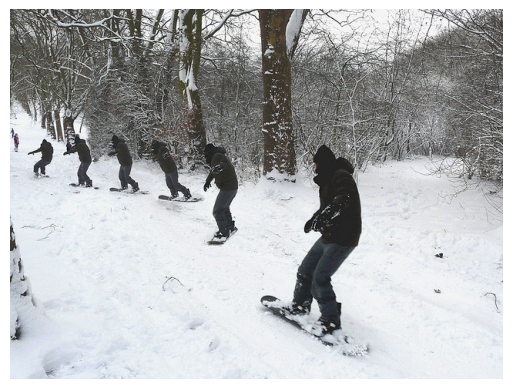

Question 393271001: Does this appear to be a photo of multiple exposures of the black clad snowboarder?
Answer: yes
Explanation: the figure is dressed the same going down a hill
Explanation: it seems to be the same snowboarder doing different tricks
Explanation: the same snowboarder is present many times


Question 393284000: Is this a beach scene?
Answer: no
Explanation: the ground is covered in snow
Explanation: there is snow on the ground and the person in this image is snowboarding
Explanation: there is a lot of snow and a man snowboarding


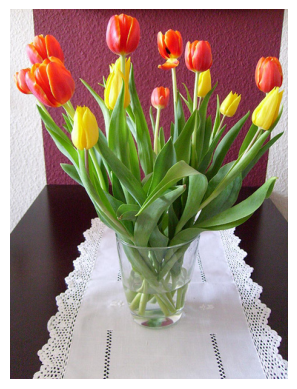

Question 393338001: What kind of flowers are in the vase?
Answer: tulips
Explanation: they are yellow and red with petals shaped in an oval
Explanation: they look like they are made of two lips
Explanation: they are bright spring flowers shaped like a u


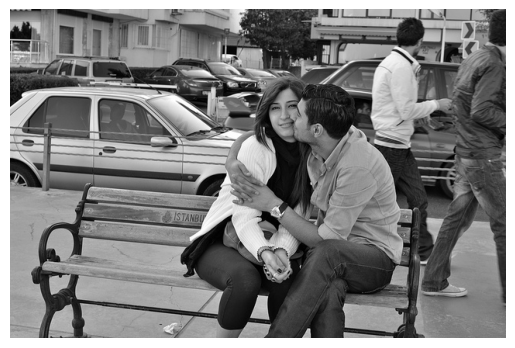

Question 524436004: Is it raining?
Answer: no
Explanation: the young couple are kissing on the bench and they are completely dry
Explanation: water is not on the tops of the cars
Explanation: there is no water anywhere and nothing is wet


Question 262531001: What is the man in the hat doing?
Answer: skateboarding
Explanation: he's riding on a skateboard
Explanation: he is bent low atop a board with wheels
Explanation: he is riding on a skateboard


Question 262608003: Is rice part of this meal?
Answer: yes
Explanation: there is food on a plate
Explanation: i can see rice underneath the meat and next to the vegetables
Explanation: there is rice mixed in with the food


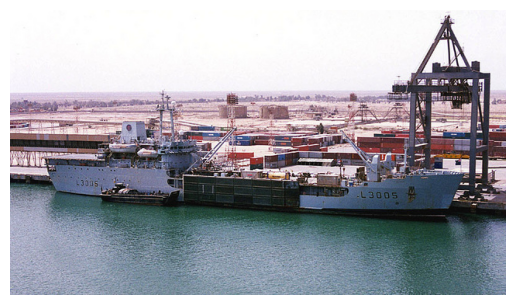

Question 262651002: Is this a leisure boat?
Answer: no
Explanation: this boat is a large barge
Explanation: it is designed to move cargo
Explanation: it is a large boat for cargo


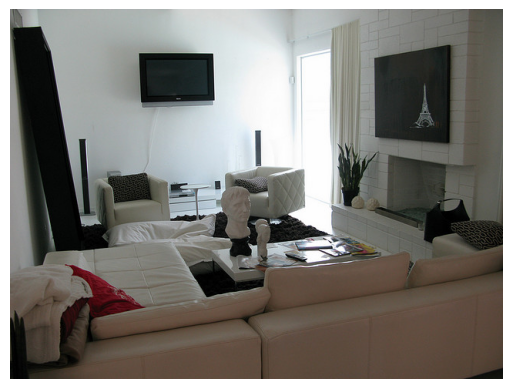

Question 524822007: What room is this?
Answer: living room
Explanation: it is one room with couches and a tv
Explanation: this room has a fireplace, a couch, multiple armchairs, and a television mounted on the wall
Explanation: there is a sectional couch and a television and fire place


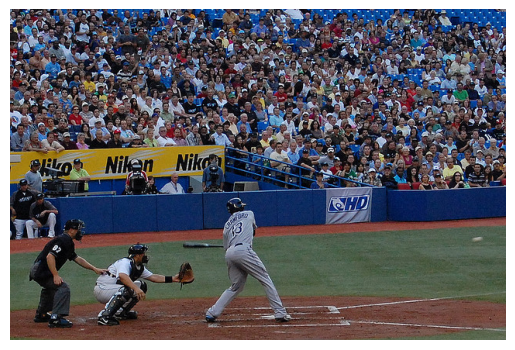

Question 544006: What are they playing?
Answer: baseball
Explanation: a man in uniform is swinging his bat at a baseball coming towards him
Explanation: the batter, who is standing next to home plate, has just swung his baseball bat and hit a baseball
Explanation: there is a batter and catcher at home base


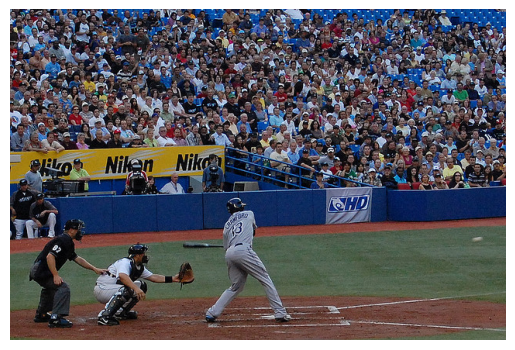

Question 544014: What sport is this?
Answer: baseball
Explanation: in the crowd filled stadium the fans watch the batter swing
Explanation: the man is swinging a bat at the ball
Explanation: a catcher, with a catcher's mitt is squatting behind home plate


In [11]:
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

def most_common_answer(answers):
    answers = [ans['answer'] for ans in answers]
    return Counter(answers).most_common(1)[0][0]

# visualize image, question, answer and explanations of a sample
count = 0
for key,value in val_data.items():
    value['answer'] = most_common_answer(value['answers'])
    image_name = value['image_name']
    image_path = os.path.join(val_dir, image_name)
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print(f"Question {key}: {value['question']}")
    print(f"Answer: {value['answer']}")
    for explan in value['explanation']:
        print(f"Explanation: {explan}")
    count += 1
    if count == 10:
        break
    